```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

In this notebook we will load the true state, and simply take a look on the data we got.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Investigating the truth

In this notebook we will load the true state, and simply take a look on the data we got.

## Set environment

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc

import pycuda.driver as cuda
import os
import sys
import datetime

from importlib import reload
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Import our simulator
from SWESimulators import IPythonMagic, SimReader, Observation, DoubleJetCase

In [2]:
%cuda_context_handler gpu_ctx

### The data path

In [3]:
truth_path = os.path.abspath('presented_data/true_state/')


### Define functions for plotting

In [4]:
def imshow(im, interpolation="None", title=None, figsize=(4,4), interior=False):
    fig = plt.figure(figsize=figsize)
    
    if interior:
        im = plt.imshow(im[2:-2,2:-2], interpolation=interpolation, origin='lower')
    else:
        im = plt.imshow(im, interpolation=interpolation, origin='lower')
    
    plt.colorbar()
    if title is not None:
        plt.title(title)
        
def imshow3(eta, hu, hv, interpolation="None", title=None, figsize=(12.5,3.4), interior=False):
    fig, axs = plt.subplots(1,3, figsize=figsize)
    
    eta_cmap = 'BrBG'
    huv_cmap = 'RdBu'
    
    range_eta = np.max(np.abs(eta))
    range_huv = max(np.max(np.abs(hu)), np.max(np.abs(hv)))
    
    range_eta = 3.5
    range_huv = 625
    
    if interior:
        eta_im = axs[0].imshow(eta[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_eta, vmax=range_eta, cmap=eta_cmap)
    else:
        eta_im = axs[0].imshow(eta, interpolation=interpolation, origin='lower', vmin=-range_eta, vmax=range_eta, cmap=eta_cmap)
    axs[0].set_title("$\eta$")
    plt.colorbar(eta_im, ax=axs[0])
    
    if interior:
        hu_im = axs[1].imshow(hu[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv, cmap=huv_cmap)
    else:
        hu_im = axs[1].imshow(hu, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv, cmap=huv_cmap)
    axs[1].set_title("$hu$")
    plt.colorbar(hu_im, ax=axs[1])

    if interior:
        hv_im = axs[2].imshow(hv[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv, cmap=huv_cmap)
    else:
        hv_im = axs[2].imshow(hv, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv, cmap=huv_cmap)
    axs[2].set_title("$hv$")
    plt.colorbar(hv_im, ax=axs[2])

    if title is not None:
        plt.suptitle(title)
    plt.tight_layout()
    
def plotDrifters(observations, sim_reader, t, drifter_set=[]):
    drifter_positions = observations.get_drifter_position(t)

    fig = plt.figure(figsize=(7,7))
    ax = plt.subplot(111)
    nx, ny = sim_reader.get('nx'), sim_reader.get('ny')
    dx, dy = sim_reader.get('dx'), sim_reader.get('dy')

    emptyData =np.ma.masked_where(np.zeros((ny,nx)) > 1, np.zeros((ny,nx)))
    ax.imshow(emptyData, origin="lower", extent=[0, nx*dx, 0, ny*dy], cmap='binary')

    for i in range(drifter_positions.shape[0]):
        color = 'xkcd:pale cyan'
        if i in drifter_set:
            color = 'xkcd:tomato red'
        circ_end = matplotlib.patches.Circle((drifter_positions[i,0], drifter_positions[i,1]),
                                             3000, fill=True, zorder=10, color=color)
        ax.add_patch(circ_end)

    
def days_to_sec(days):
    return days*24*60*60

def truth_time_step(t):
    t = t - days_to_sec(3)
    return int(t/(60*60))

# The double jet steady state

In [5]:
djc = DoubleJetCase.DoubleJetCase(gpu_ctx)

Text(0.5, 1.0, '$hv$')

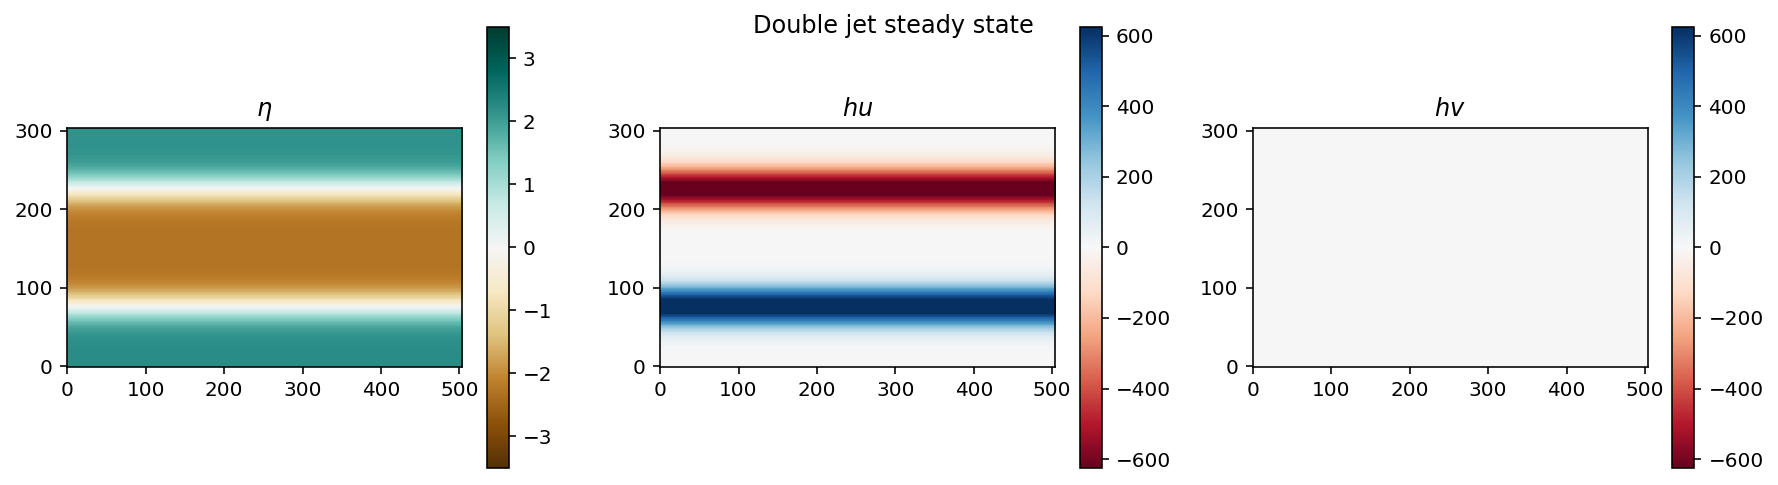

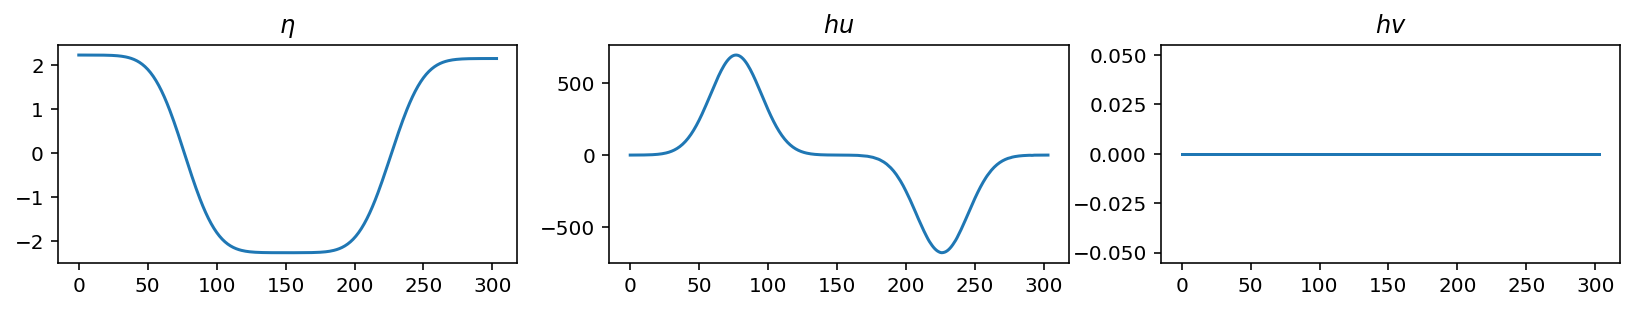

In [6]:
imshow3(djc.base_cpu_eta, djc.base_cpu_hu, djc.base_cpu_hv, title='Double jet steady state')
fig, axs = plt.subplots(1,3,figsize=(14,2))

axs[0].plot(djc.base_cpu_eta[:, 100])
axs[0].set_title(r'$\eta$')

axs[1].plot(djc.base_cpu_hu[:, 100])
axs[1].set_title(r'$hu$')

axs[2].plot(djc.base_cpu_hv[:, 100])
axs[2].set_title(r'$hv$')

# Read truth and investigate

Reading files...

In [7]:
truth_state_filename = os.path.join(truth_path, "double_jet_case_truth.nc")
observations_filename = os.path.join(truth_path, "drifter_observations.pickle")

truth_reader = SimReader.SimNetCDFReader(truth_state_filename)
observations = Observation.Observation()
observations.read_pickle(observations_filename)

## Function for finding max dt

In [8]:
mean_H = truth_reader.getH().mean()
dx = truth_reader.get('dx')
dy = truth_reader.get('dy')
g = truth_reader.get('g')
print('mean_H', mean_H)
def maxTimeStep(eta, hu, hv):
    h = eta + mean_H
    u = hu/h
    v = hv/h
    dt = 0.8*0.25*min( dx/np.max(np.abs(u) + np.sqrt(g*h)),
                       dy/np.max(np.abs(v) + np.sqrt(g*h)) )
    return dt
    

mean_H 227.7761


## Plot state

max dt at day 3 8.782910919189453
max dt at day 4 8.768906402587891
max dt at day 5 8.75601577758789
max dt at day 6 8.816590881347656
max dt at day 7 8.939508819580078
max dt at day 8 8.941407012939454
max dt at day 9 8.909844970703125
max dt at day 10 8.864631652832031
max dt at day 11 8.884536743164062
max dt at day 12 8.905061340332031
max dt at day 13 8.91718215942383
6.666666666666667


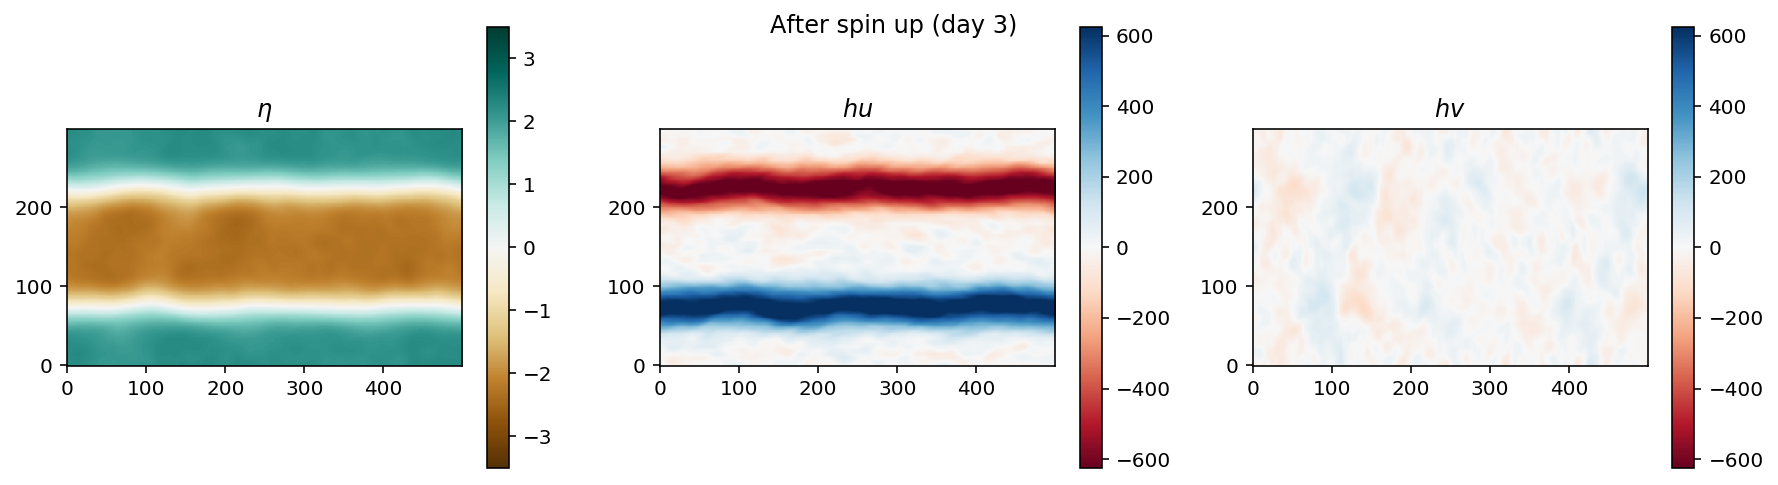

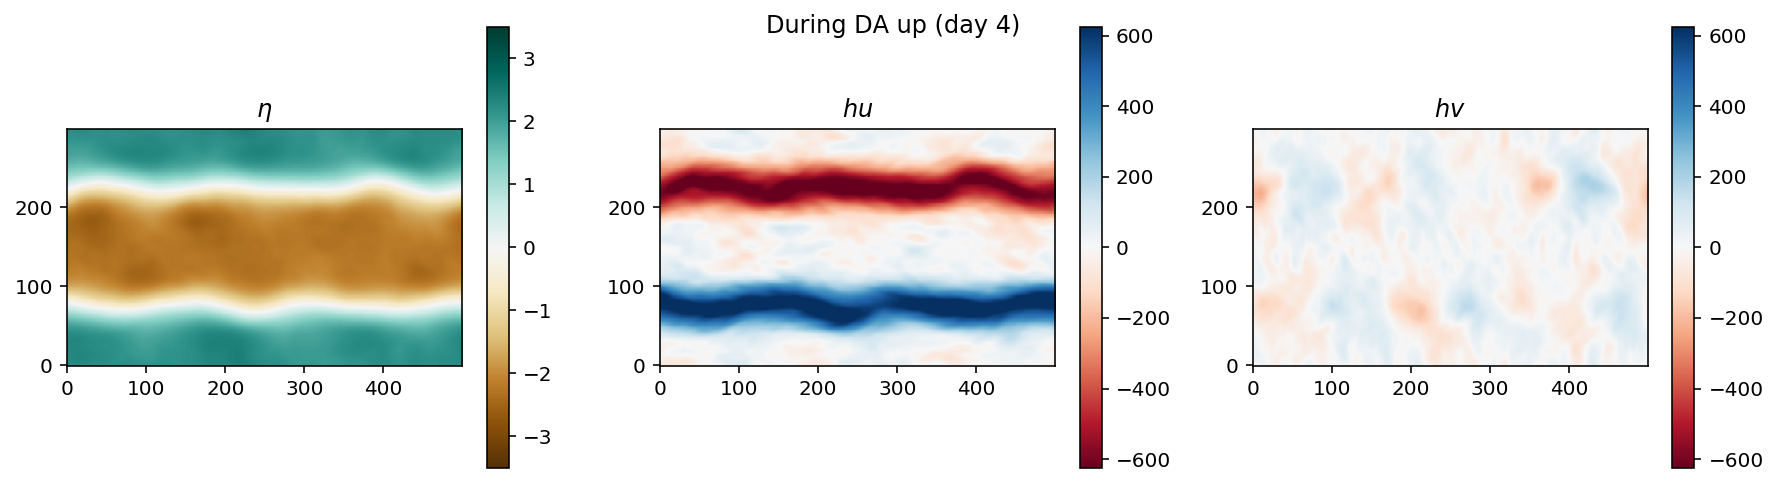

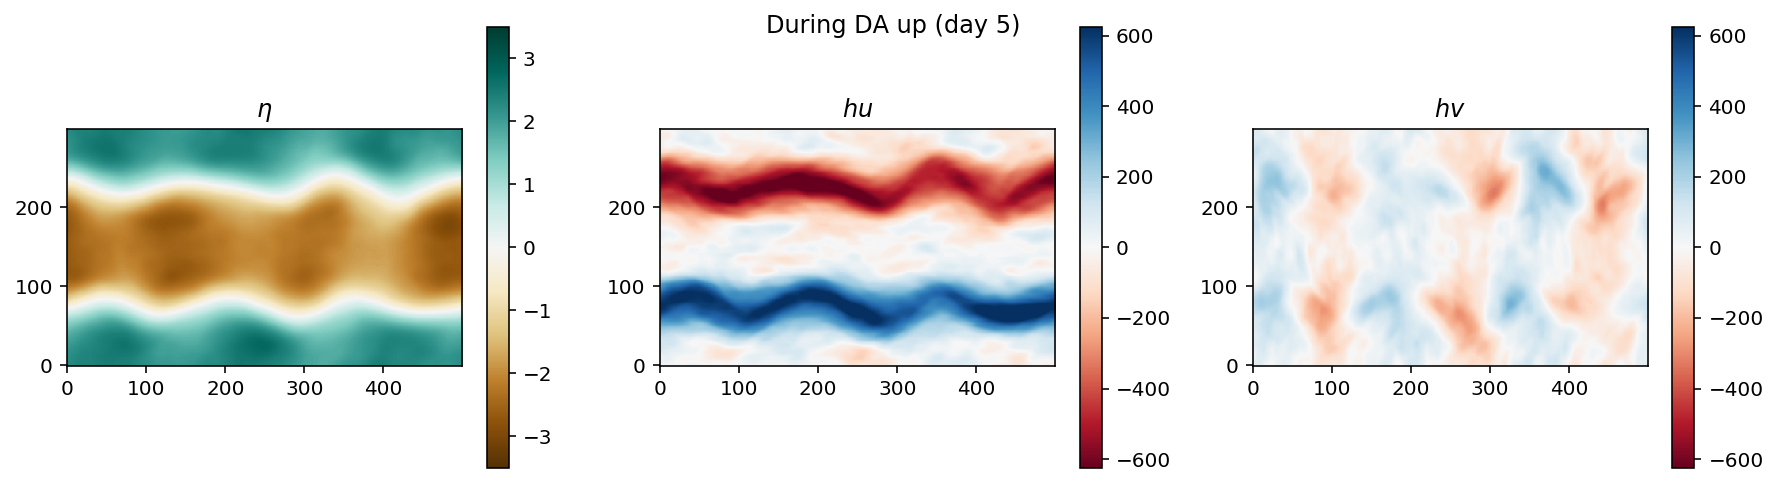

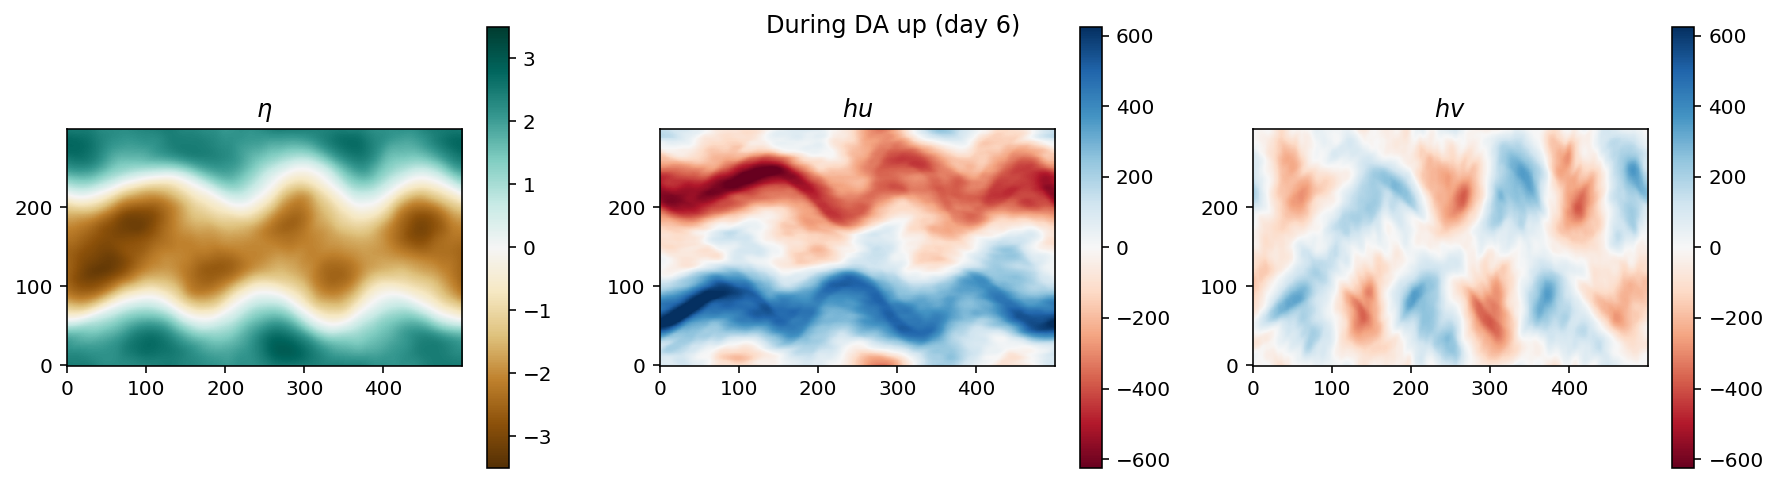

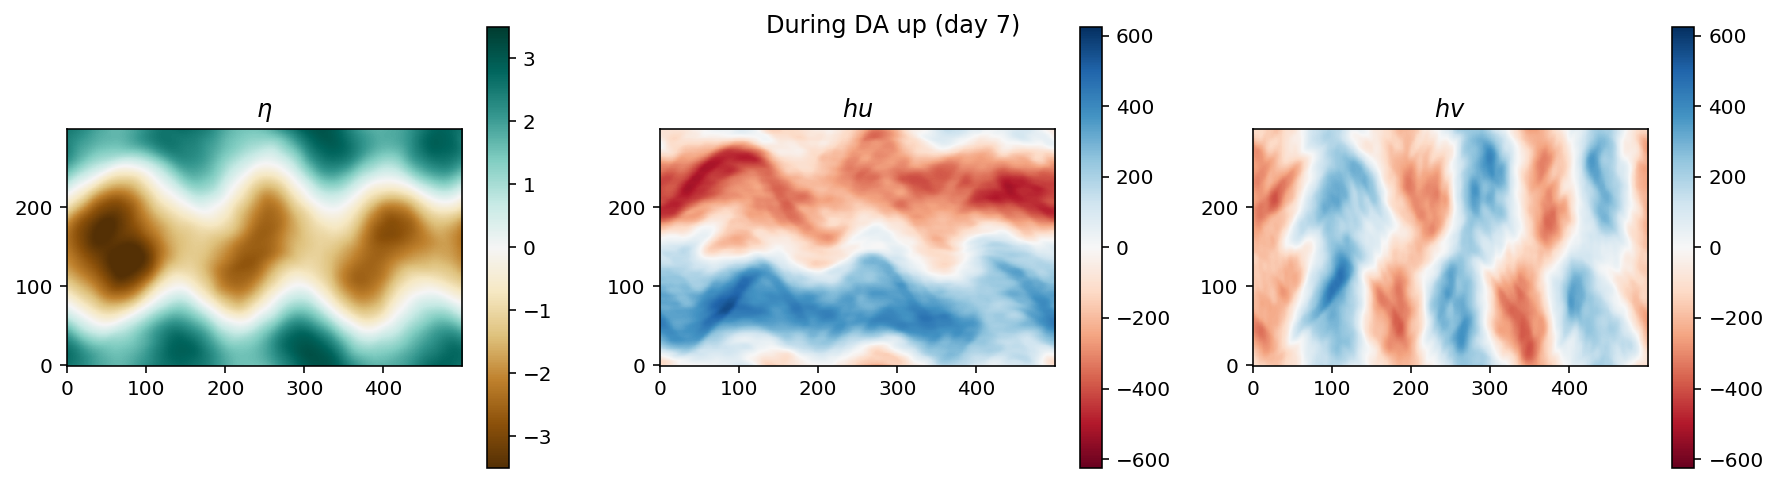

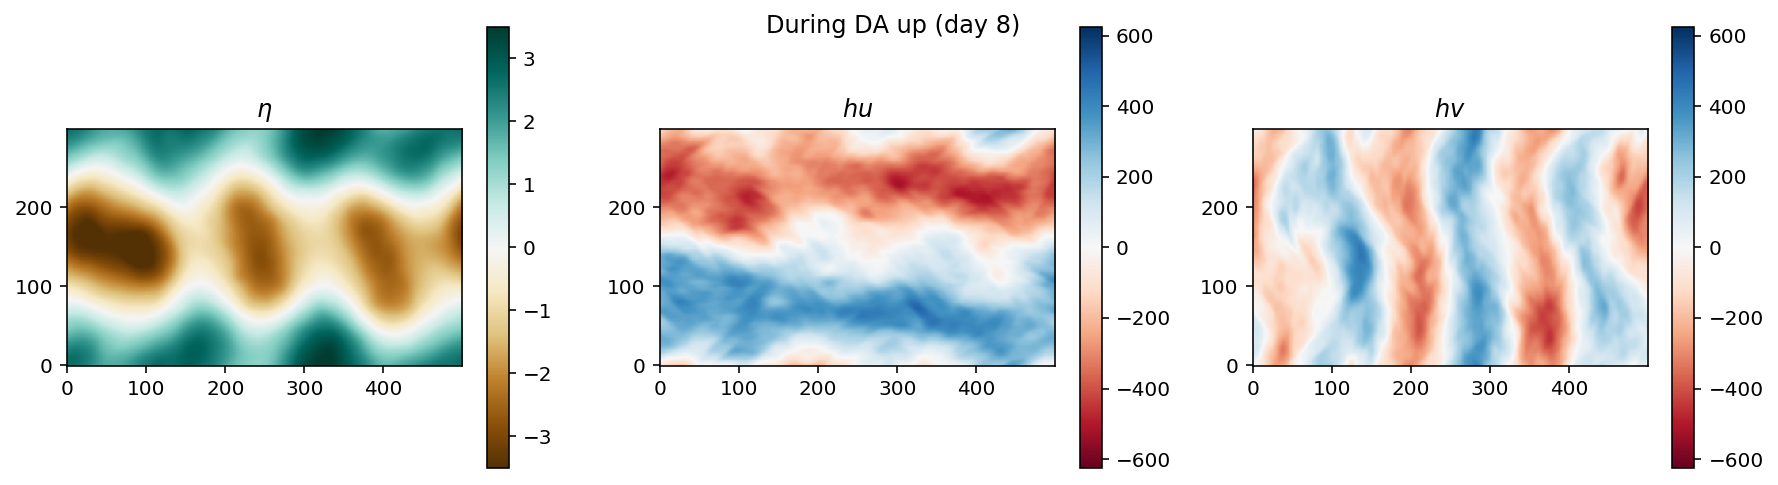

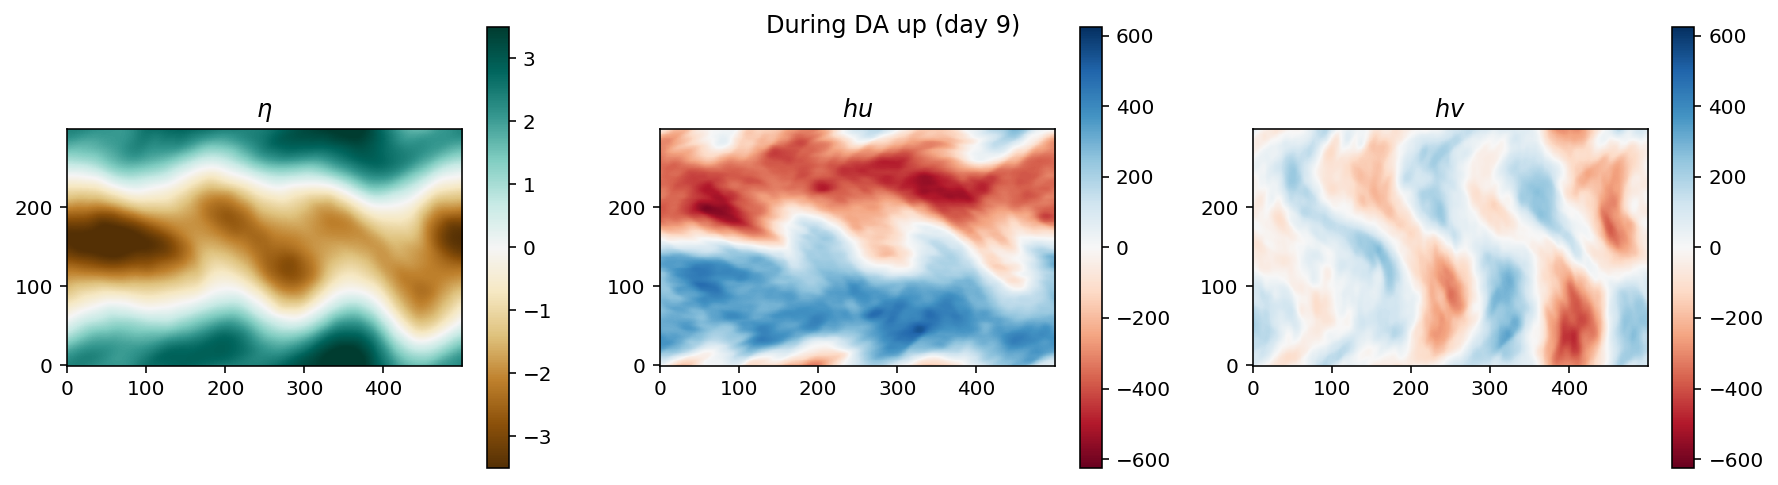

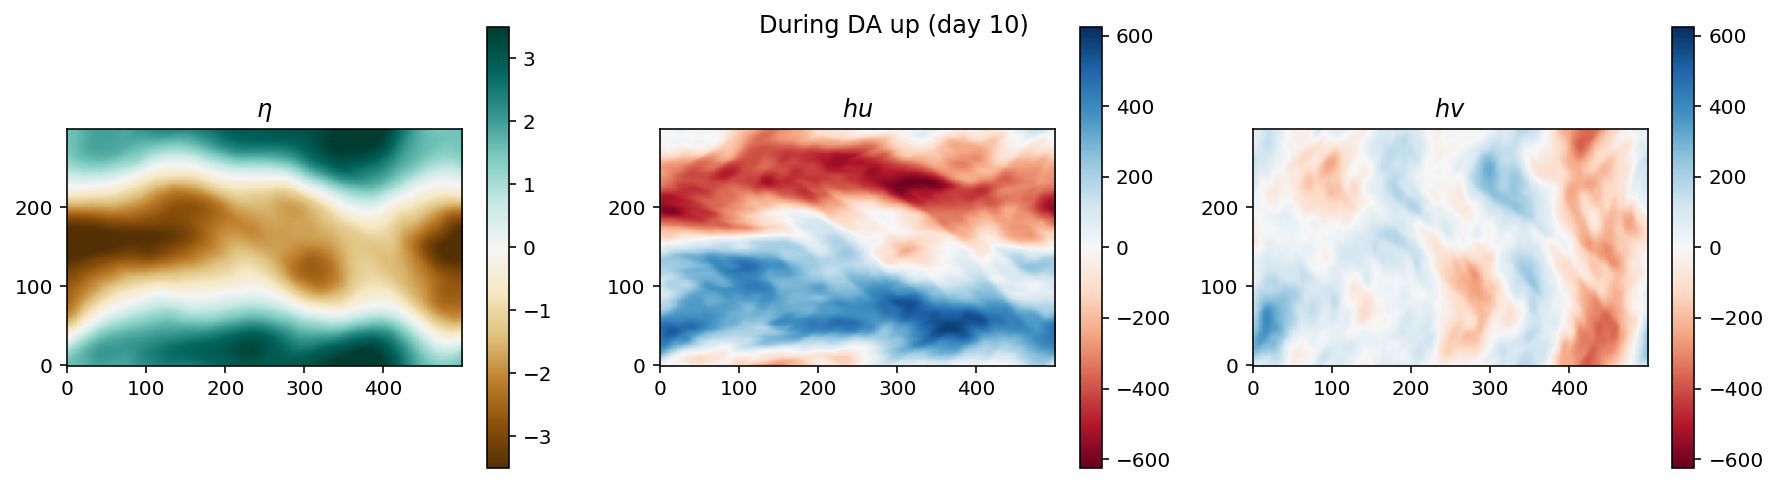

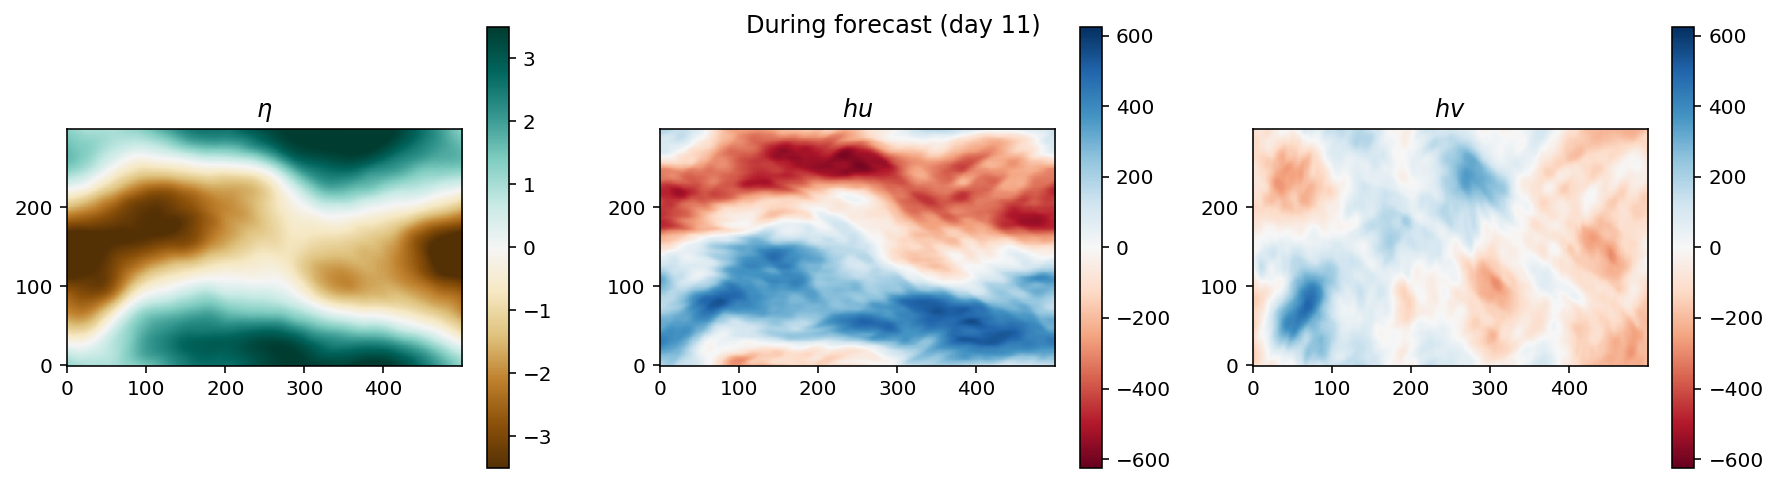

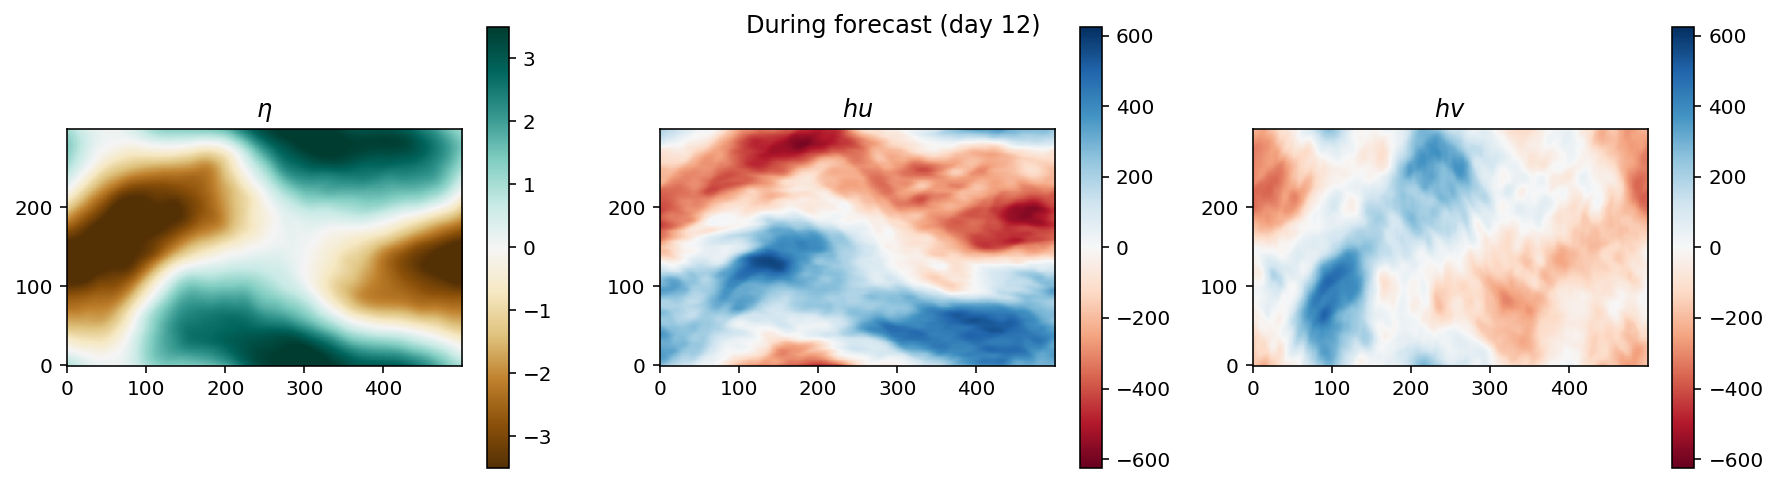

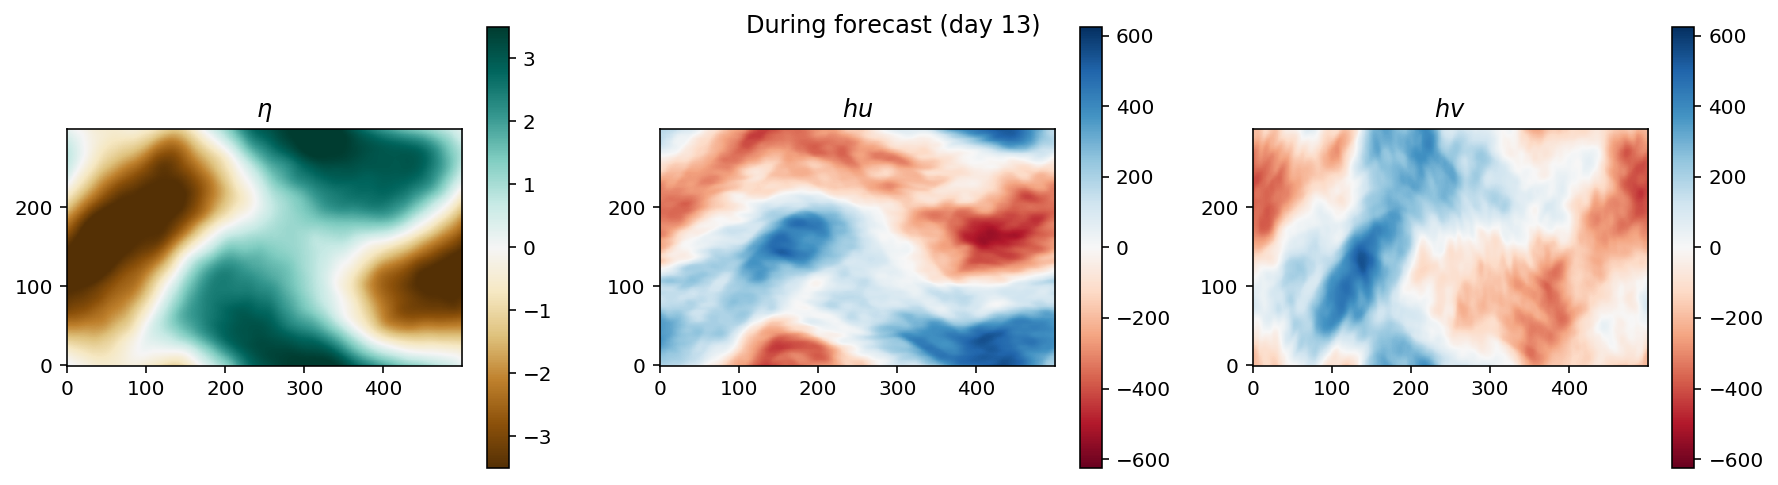

In [9]:
for day in range(3,14):
    title = None
    if day == 3:
        title = "After spin up"
    elif day < 11:
        title = "During DA up"
    else:
        title = "During forecast"
    title = title + " (day " + str(day) + ")"
    t = days_to_sec(day)
    t_index = truth_time_step(t)
    eta, hu, hv, t = truth_reader.getTimeStep(t_index)
    imshow3(eta, hu, hv, title=title)
    print('max dt at day ' + str(day), maxTimeStep(eta, hu, hv))

print(60/9)

# Plot state and drifters 
Look at 
- spin up state (day 3) 
- mid-DA state (day 6.5)
- Now-state (day 10)
- Forecast state (day 13)


In [10]:
drifter_set = np.arange(0, 64, 7)
drifter_set = np.array([ 2,  7, 12, 24, 29, 35, 41, 48, 53, 60])
print(len(drifter_set))
print(drifter_set)

10
[ 2  7 12 24 29 35 41 48 53 60]


259200.0 259200


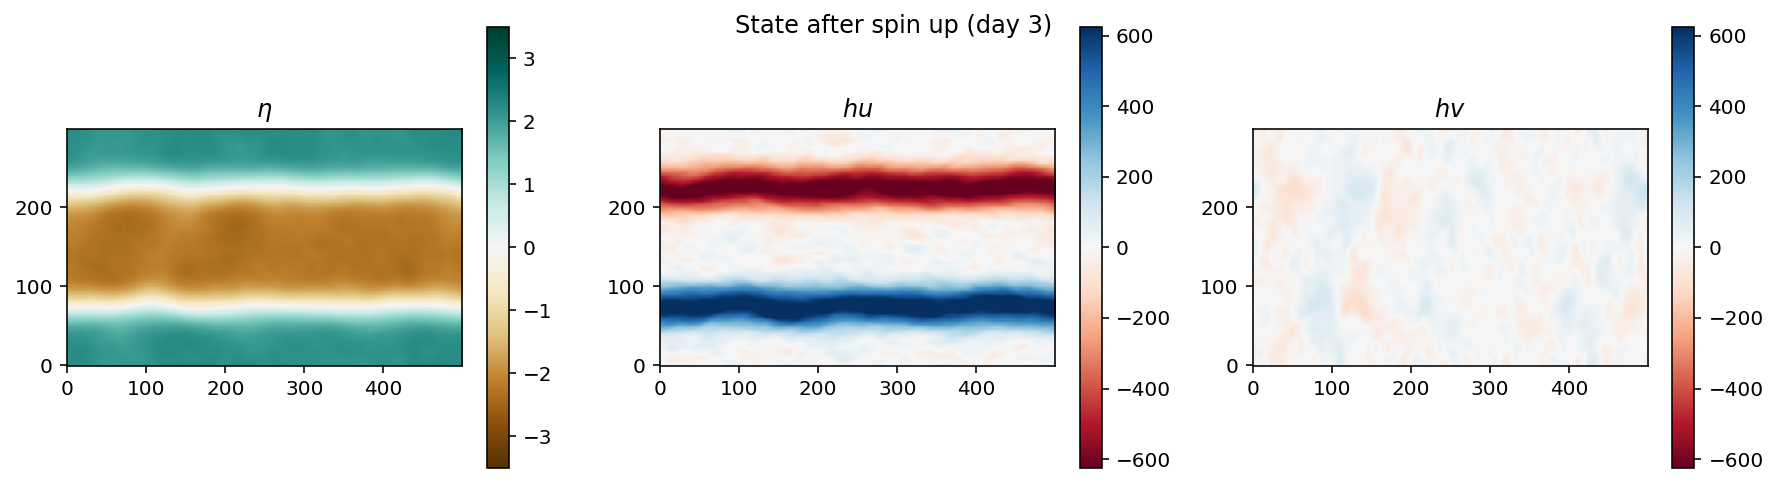

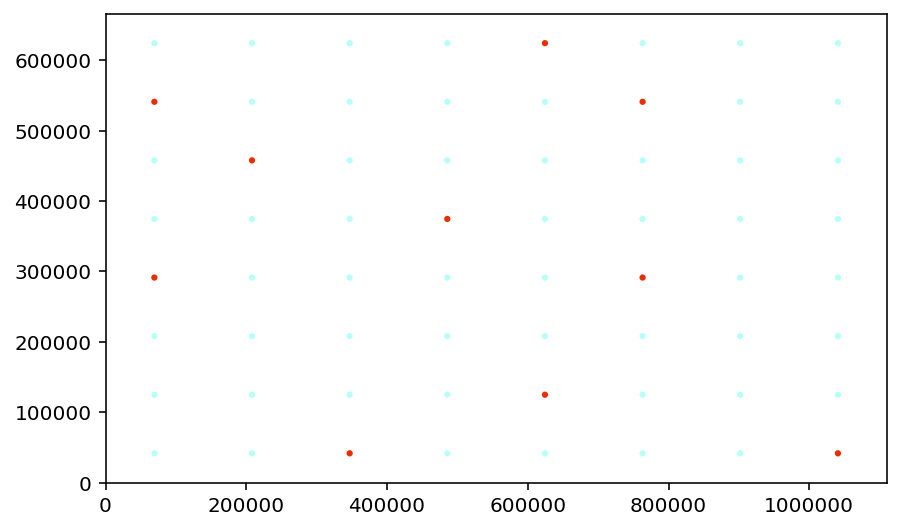

In [11]:
t_spinup = days_to_sec(3)
t_spinup_index = truth_time_step(t_spinup)
eta, hu, hv, t = truth_reader.getTimeStep(t_spinup_index)

print(t, t_spinup)
imshow3(eta, hu, hv, title='State after spin up (day 3)')

plotDrifters(observations, truth_reader, t_spinup, drifter_set)

518400.0 518400


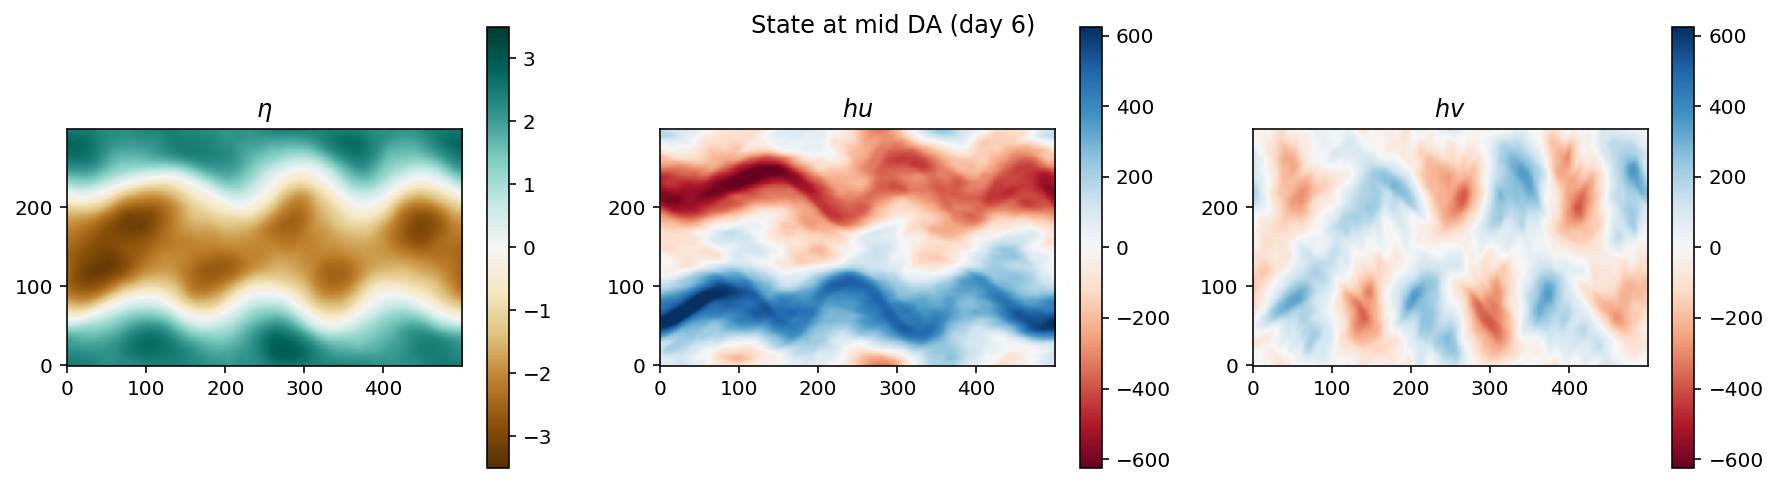

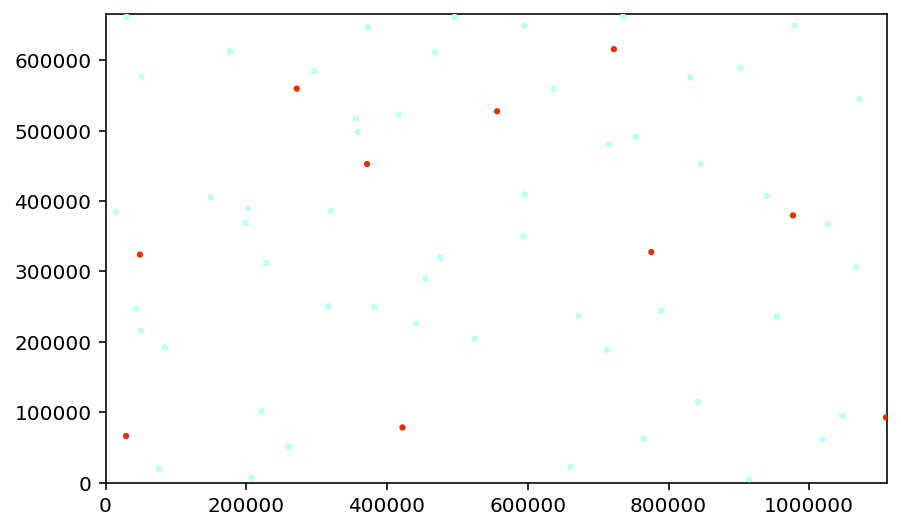

In [12]:
t_midDA = days_to_sec(6)
t_midDA_index = truth_time_step(t_midDA)
eta, hu, hv, t = truth_reader.getTimeStep(t_midDA_index)

print(t, t_midDA)
imshow3(eta, hu, hv, title='State at mid DA (day 6)')

plotDrifters(observations, truth_reader, t_midDA, drifter_set)

691200.0 691200


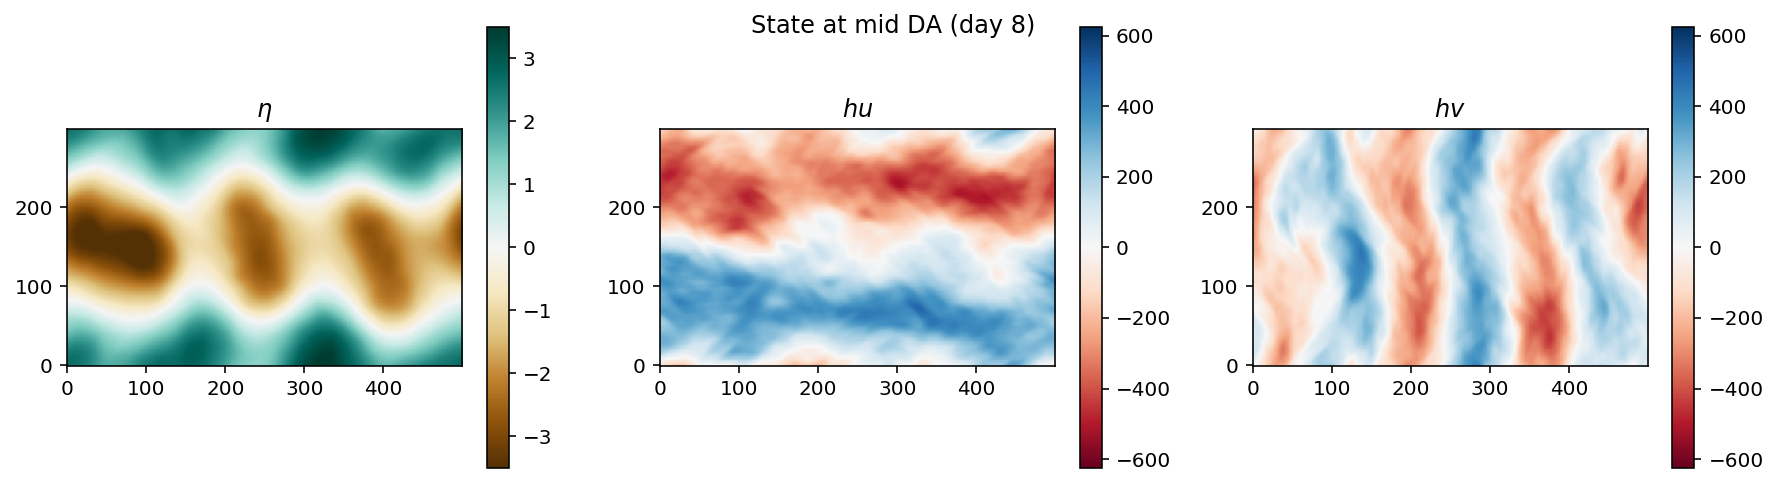

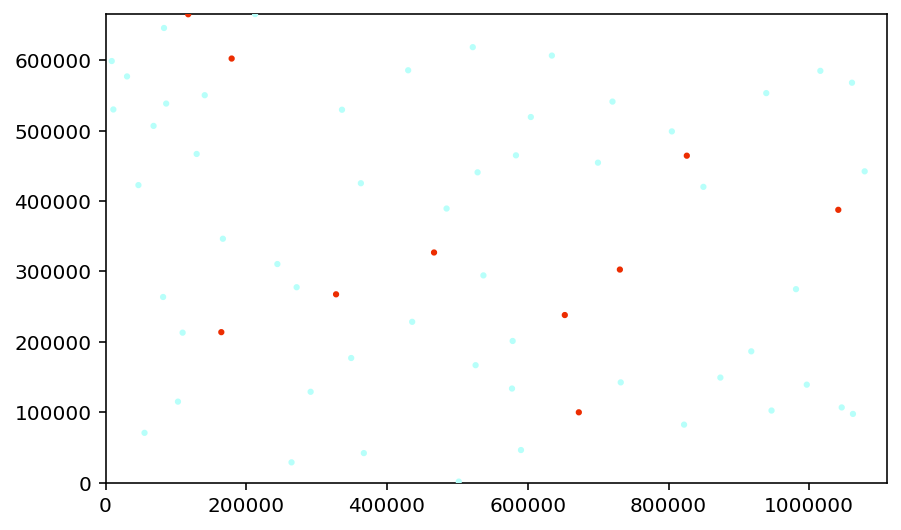

In [13]:
t_midDA = days_to_sec(8)
t_midDA_index = truth_time_step(t_midDA)
eta, hu, hv, t = truth_reader.getTimeStep(t_midDA_index)

print(t, t_midDA)
imshow3(eta, hu, hv, title='State at mid DA (day 8)')

plotDrifters(observations, truth_reader, t_midDA, drifter_set)

864000.0 864000


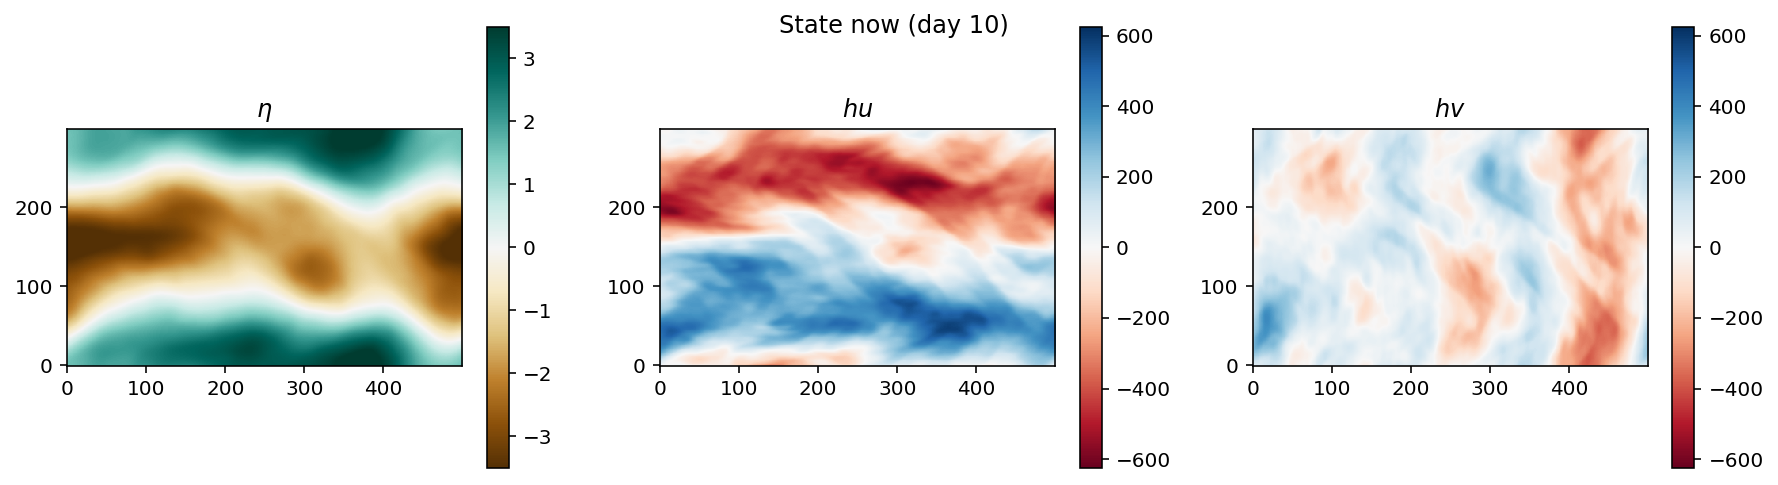

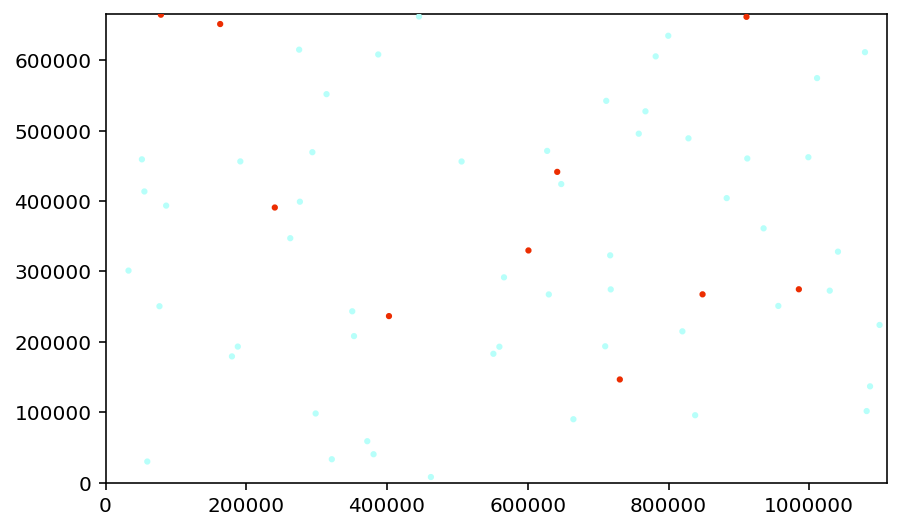

In [14]:
t_now = days_to_sec(10)
t_now_index = truth_time_step(t_now)
eta, hu, hv, t = truth_reader.getTimeStep(t_now_index)

print(t, t_now)
imshow3(eta, hu, hv, title='State now (day 10)')

plotDrifters(observations, truth_reader, t_now, drifter_set)

1123200.0 1123200


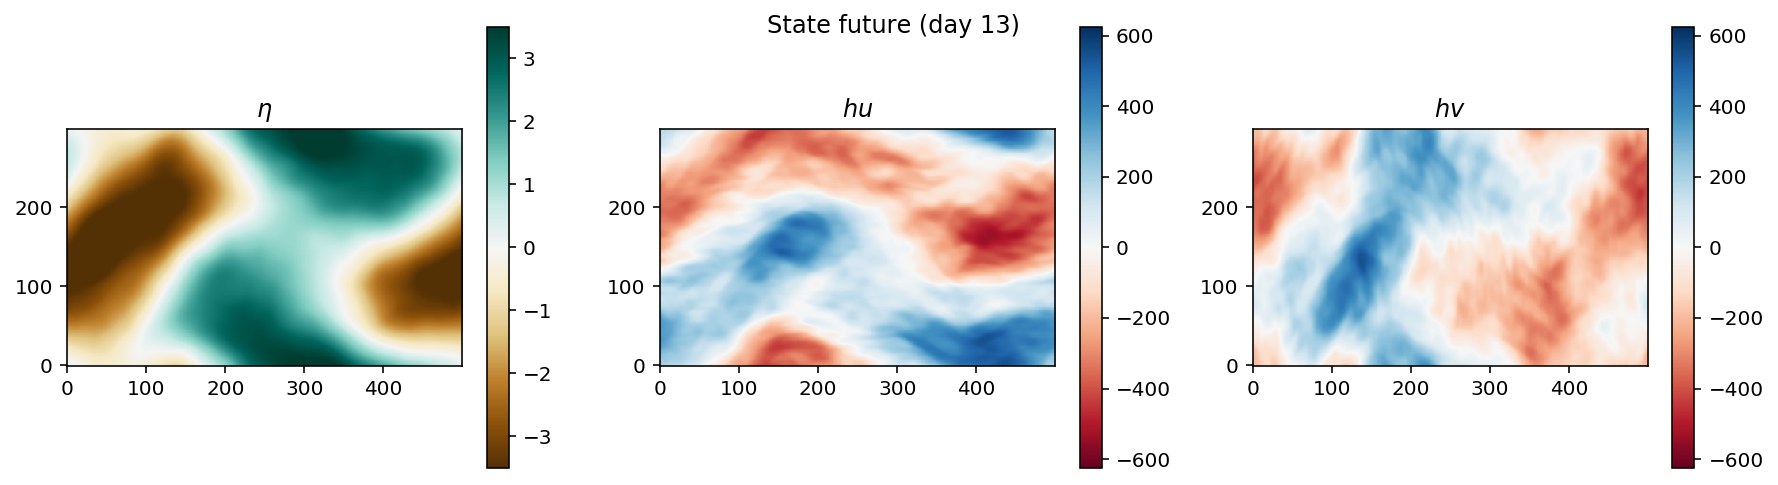

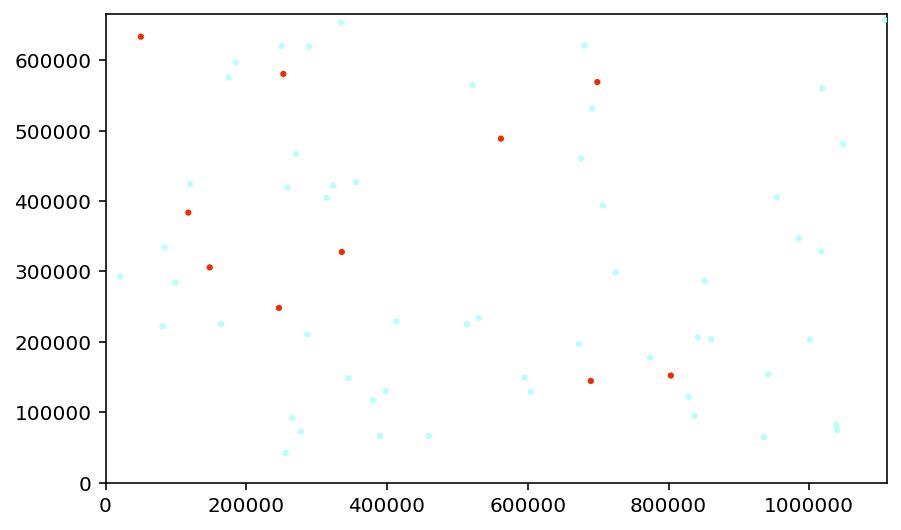

In [15]:
t_future = days_to_sec(13)
t_future_index = truth_time_step(t_future)
eta, hu, hv, t_last = truth_reader.getLastTimeStep()

print(t_last, t_future)
imshow3(eta, hu, hv, title='State future (day 13)')

plotDrifters(observations, truth_reader, t_future, drifter_set)

# Drifter paths
Gray paths are in the data-assimilation period. Green/lime is the true trajectories during forecasting.

drifter set: [ 2  7 12 24 29 35 41 48 53 60]
getting path for drifter 2
getting path for drifter 7
getting path for drifter 12
getting path for drifter 24
getting path for drifter 29
getting path for drifter 35
getting path for drifter 41
getting path for drifter 48
getting path for drifter 53
getting path for drifter 60


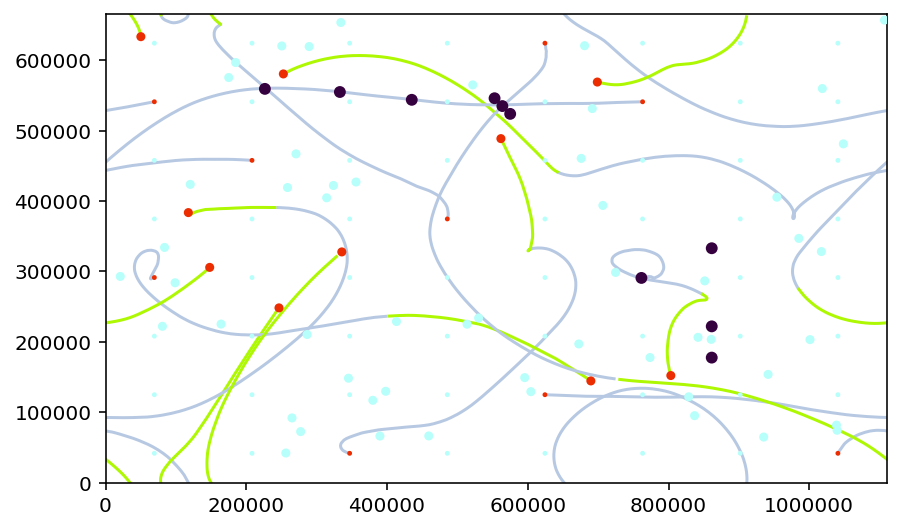

In [16]:
times_da = np.arange(days_to_sec(3), days_to_sec(10), 60*60)
times_f  = np.arange(days_to_sec(10), days_to_sec(13), 60*60)

fig = plt.figure(figsize=(7,7))
ax = plt.subplot(111)
nx, ny = truth_reader.get('nx'), truth_reader.get('ny')
dx, dy = truth_reader.get('dx'), truth_reader.get('dy')

emptyData =np.ma.masked_where(np.zeros((ny,nx)) > 1, np.zeros((ny,nx)))
ax.imshow(emptyData, origin="lower", extent=[0, nx*dx, 0, ny*dy], cmap='binary')

print('drifter set:', drifter_set)
for drifter_id in drifter_set:
    print('getting path for drifter ' + str(drifter_id))
    paths_da = observations.get_drifter_path(drifter_id, times_da[0], times_da[-1], in_km=False)
    for path in paths_da:
        ax.plot(path[:,0], path[:,1], color='xkcd:light blue grey')
    
    paths_f = observations.get_drifter_path(drifter_id, times_f[0], times_f[-1], in_km=False)
    for path in paths_f:
        ax.plot(path[:,0], path[:,1], color='xkcd:lemon green')

drifter_positions_start = observations.get_drifter_position(t_spinup)
for i in range(drifter_positions_start.shape[0]):
    color = 'xkcd:pale cyan'
    if i in drifter_set:
        color = 'xkcd:tomato red'
    circ_end = matplotlib.patches.Circle((drifter_positions_start[i,0], drifter_positions_start[i,1]),
                                         2000, fill=True, zorder=10, color=color)
    ax.add_patch(circ_end)
    
drifter_positions_end = observations.get_drifter_position(t_future)
for i in range(drifter_positions_end.shape[0]):
    color = 'xkcd:pale cyan'
    if i in drifter_set:
        color = 'xkcd:tomato red'
    circ_end = matplotlib.patches.Circle((drifter_positions_end[i,0], drifter_positions_end[i,1]),
                                         5000, fill=True, zorder=10, color=color)
    ax.add_patch(circ_end)
    
extraCells = np.array([[254, 241], # Cross with two trajectories
                       [249, 246], # northwest of above
                       [259, 236], # southeast of above
                       [343, 131], # Closed circle of same drifter
                       [196,  245], # Middle of single trajectory
                       [150,  250], # Middle of single trajectory, later than above
                       [102, 252], # On the same trajectory as the above, but later, and also in a intersection
                       [ 388, 100], # Unobserved area just north of southern jet
                       [ 388, 80],  # Unobserved area in southern jet
                       [ 388, 150], # Unobserved area in calm area
                      ])
for i in range(extraCells.shape[0]):
    color = 'xkcd:deep purple'
    circ_end = matplotlib.patches.Circle((extraCells[i,0]*truth_reader.get('dx'), 
                                          extraCells[i,1]*truth_reader.get('dy')),
                                         7000, fill=True, zorder=15, color=color)
    ax.add_patch(circ_end)